In [7]:
%pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 43.7 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Installation de toutes les dépendances du projet
%pip install pandas numpy matplotlib seaborn scikit-learn folium geopy scipy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CHARGEMENT DES DONNÉES ---
print("📥 Chargement du dataset...")
df = pd.read_csv('airline.csv')

# --- 2. TRAITEMENT DES VALEURS MANQUANTES ---
# Sélection des colonnes quantitatives
ratings_cols = ['seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 
                'inflight_entertainment_rating', 'value_money_rating']

# Étape A : Suppression des entrées trop incomplètes (Seuil de fiabilité)
# On exige au moins 3 notes renseignées sur 5 pour garder l'avis
df = df.dropna(subset=ratings_cols, thresh=3)

# Étape B : Imputation des données manquantes résiduelles
# Remplacement des NaN restants par la médiane de chaque colonne
for col in ratings_cols:
    df[col] = df[col].fillna(df[col].median())

# Étape C : Filtrage des commentaires textuels
# Suppression des avis vides ou trop courts (< 5 mots)
df = df.dropna(subset=['content'])
df['text_len'] = df['content'].apply(lambda x: len(str(x).split()))
df = df[df['text_len'] > 5]

# --- 3. STANDARDISATION ET EXPORT ---
# Renommage des colonnes pour simplifier l'accès
cols = {
    'content': 'text',
    'recommended': 'target',
    'seat_comfort_rating': 'seat',
    'cabin_staff_rating': 'staff',
    'food_beverages_rating': 'food',
    'inflight_entertainment_rating': 'entertainment',
    'value_money_rating': 'value'
}
df = df[cols.keys()].rename(columns=cols)

# Binarisation de la variable cible (Target)
df['target'] = df['target'].apply(lambda x: 1 if str(x).lower() in ['1', 'yes', 'true'] else 0)

# Export du fichier traité
output_name = 'airline_processed.csv'
print(f"✅ Données nettoyées. Export de {len(df)} observations vers '{output_name}'.")
df.to_csv(output_name, index=False)

📥 Chargement du dataset...
✅ Données nettoyées. Export de 33706 observations vers 'airline_processed.csv'.


⏳ Chargement des données traitées...
⚙️ Recherche du k optimal (Méthode du Coude)...


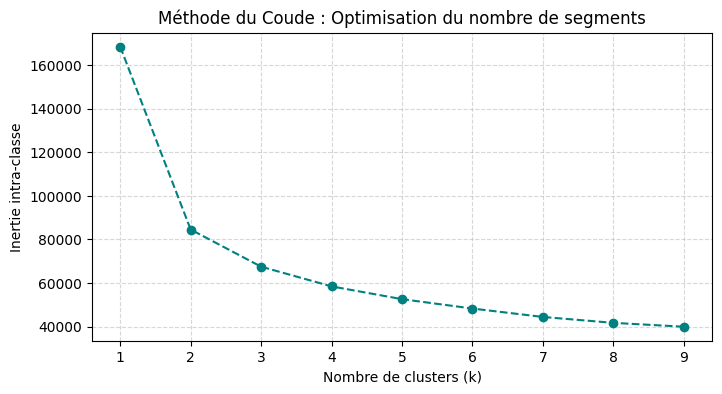

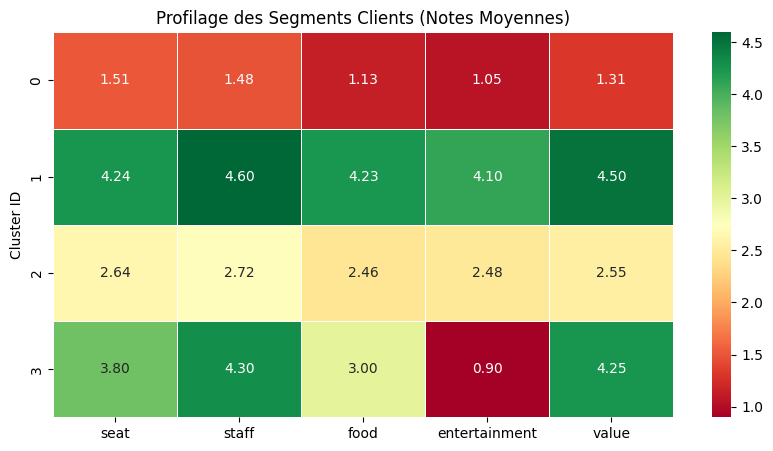

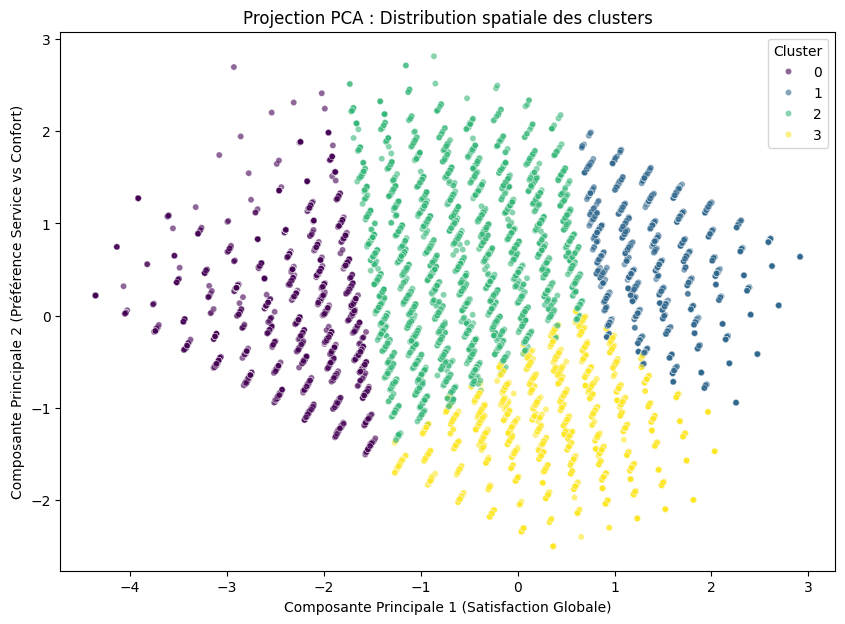

💾 Segmentation terminée. Fichier 'airline_clustered.csv' sauvegardé pour la suite.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 1. PRÉPARATION ET STANDARDISATION ---
print("⏳ Chargement des données traitées...")
# Chargement du fichier issu de l'étape précédente
df = pd.read_csv('airline_processed.csv')

# Sélection des variables actives (Notes)
features = ['seat', 'staff', 'food', 'entertainment', 'value']
X = df[features]

# Standardisation (Centrage-Réduction)
# Indispensable pour que toutes les variables aient le même poids dans le calcul de distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. DÉTERMINATION DU NOMBRE DE CLUSTERS (ELBOW METHOD) ---
print("⚙️ Recherche du k optimal (Méthode du Coude)...")
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation du Coude pour le rapport
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Méthode du Coude : Optimisation du nombre de segments', fontsize=12)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie intra-classe')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- 3. APPLICATION DU K-MEANS (k=4) ---
# Choix de 4 clusters basé sur l'analyse du coude
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# --- 4. VISUALISATION DES PROFILS ---

# A. Heatmap (Carte d'identité des clusters)
# Permet d'interpréter le comportement moyen de chaque groupe
cluster_summary = df.groupby('Cluster')[features].mean()

plt.figure(figsize=(10, 5))
sns.heatmap(cluster_summary, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)
plt.title("Profilage des Segments Clients (Notes Moyennes)", fontsize=12)
plt.ylabel("Cluster ID")
plt.show()

# B. PCA (Projection en 2 Dimensions)
# Réduction de dimension pour visualiser la séparation spatiale des groupes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['Cluster'],
    palette='viridis',
    alpha=0.6,
    s=20
)
plt.title("Projection PCA : Distribution spatiale des clusters", fontsize=12)
plt.xlabel("Composante Principale 1 (Satisfaction Globale)")
plt.ylabel("Composante Principale 2 (Préférence Service vs Confort)")
plt.legend(title='Cluster', loc='best')
plt.show()

# --- 5. EXPORT ---
output_name = 'airline_clustered.csv'
df.to_csv(output_name, index=False)
print(f"💾 Segmentation terminée. Fichier '{output_name}' sauvegardé pour la suite.")

📥 Initialisation des ressources lexicales...
⏳ Importation du dataset segmenté...
✅ Données chargées avec succès.
⚙️ Normalisation et Filtrage sémantique...
🧠 Vectorisation TF-IDF (Exclusion des termes dominants)...


c:\Users\luxni\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air'] not in stop_words.
  warnings.warn(


   -> Corpus réduit à 16905 termes significatifs.
🤖 Extraction des 5 Thèmes Latents (NMF)...
📊 Génération des profils sémantiques...


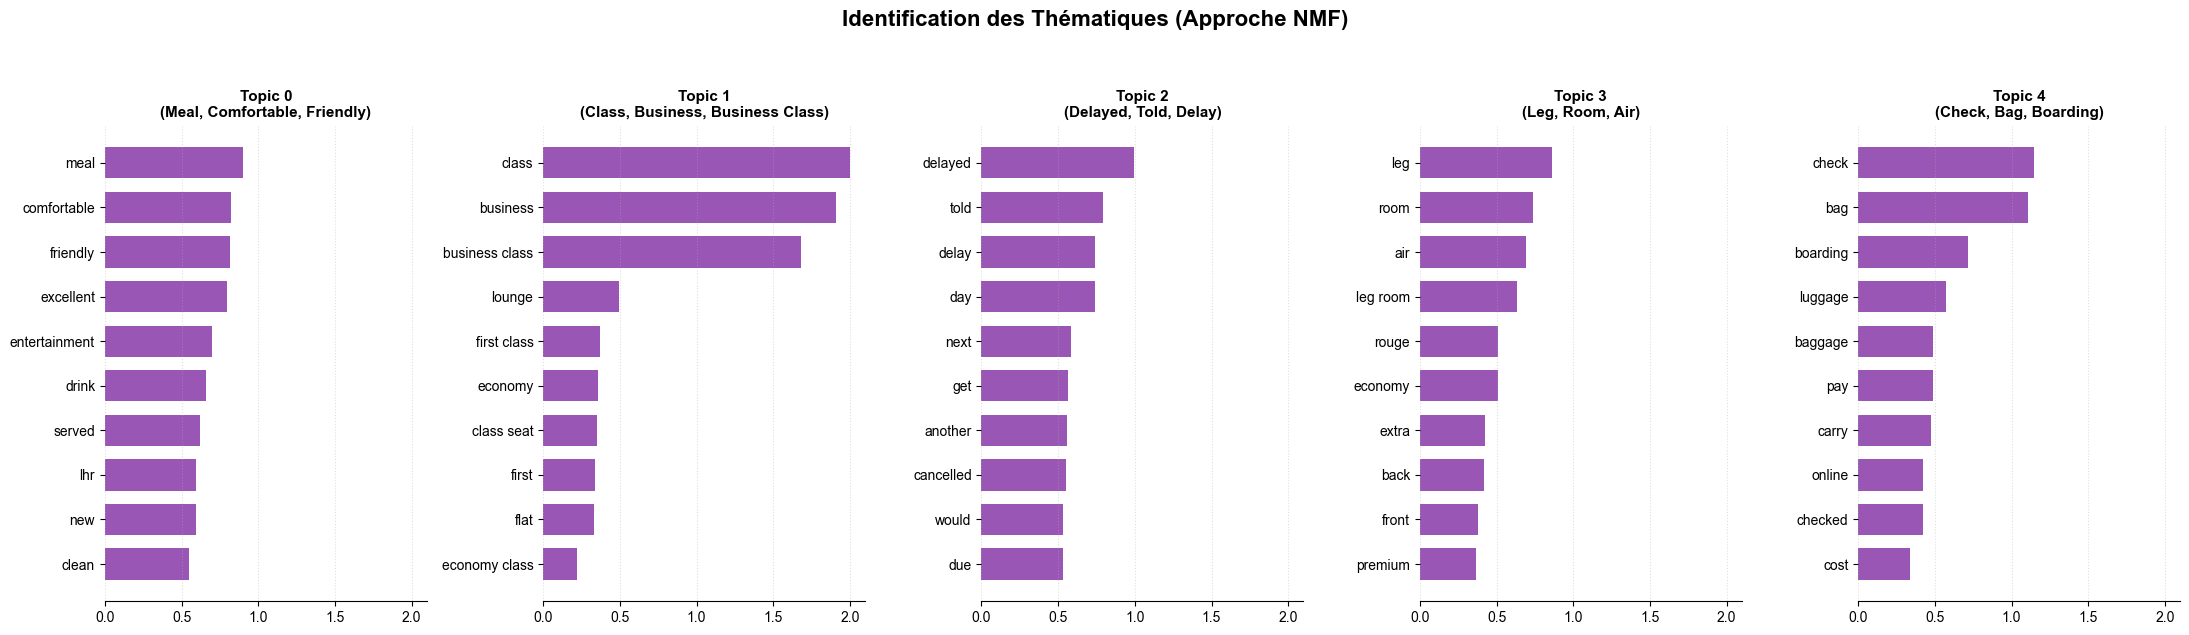

🔥 Matrice de Corrélation : Segment Client vs Sujet Dominant...


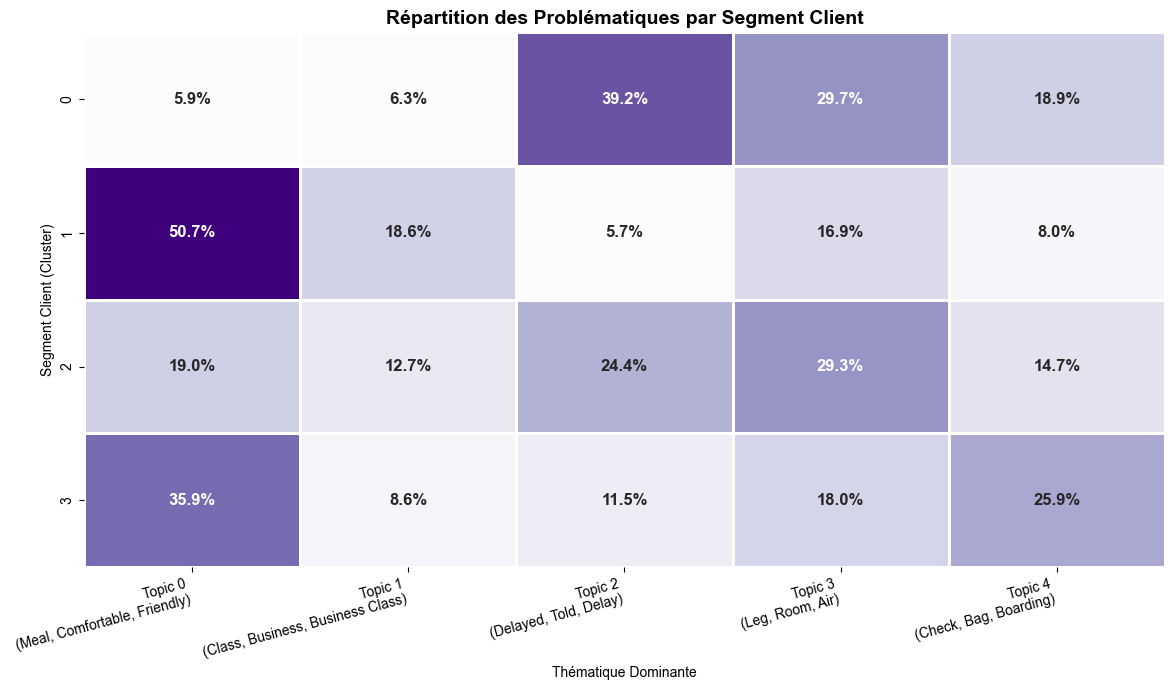

✅ Analyse terminée. Résultats exportés dans 'airline_final_analysis.csv'.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Configuration graphique "Publication Ready"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# --- 1. CONFIGURATION LINGUISTIQUE (NLTK) ---
print("📥 Initialisation des ressources lexicales...")
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
lemmatizer = WordNetLemmatizer()

# --- 2. CHARGEMENT DES DONNÉES ---
print("⏳ Importation du dataset segmenté...")
try:
    df = pd.read_csv('airline_clustered.csv')
    print("✅ Données chargées avec succès.")
except:
    df = pd.read_csv('airline_processed.csv')

df['text'] = df['text'].fillna('')

# --- 3. PRÉTRAITEMENT "LASER" (NETTOYAGE CIBLÉ) ---
print("⚙️ Normalisation et Filtrage sémantique...")

# Définition des Stop Words (Bruit de fond)
base_stops = stopwords.words('english')
# Liste étendue de mots "vides de sens" pour l'analyse métier
custom_stops = [
    'flight', 'flights', 'airline', 'airlines', 'plane', 'aircraft', 'trip', 'fly', 'flying',
    'passenger', 'passengers', 'airport', 'way', 'review', 'airways', 'travel', 'travelling',
    'service', 'staff', 'crew', 'cabin', 'time', 'hour', 'hours', 'minute', 'minutes',
    'good', 'bad', 'great', 'nice', 'ok', 'really', 'got', 'did', 'just', 
    'canada', 'toronto', 'air canada' # Suppression des entités nommées évidentes
]
final_stops = list(set(base_stops + custom_stops))

def scientific_cleaning(text):
    """Lemmatisation et suppression des mots interdits en une passe."""
    text = str(text).lower()
    tokens = text.split()
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens 
                    if word not in final_stops and len(word) > 2]
    return " ".join(clean_tokens)

df['text_clean'] = df['text'].apply(scientific_cleaning)

# --- 4. VECTORISATION TF-IDF (PONDÉRATION) ---
print("🧠 Vectorisation TF-IDF (Exclusion des termes dominants)...")

# max_df=0.4 : Exclusion des mots présents dans >40% des documents (trop génériques)
# min_df=15 : Exclusion des hapax (mots trop rares/erreurs)
vectorizer = TfidfVectorizer(max_df=0.4, min_df=15, stop_words=final_stops, ngram_range=(1, 2))

dtm = vectorizer.fit_transform(df['text_clean'])
feature_names = vectorizer.get_feature_names_out()

print(f"   -> Corpus réduit à {len(feature_names)} termes significatifs.")

# --- 5. MODÉLISATION NMF (FACTORISATION MATRICIELLE) ---
print("🤖 Extraction des 5 Thèmes Latents (NMF)...")
# NMF force les composantes à être positives, créant des sujets plus "purs" que LDA
nmf = NMF(n_components=5, random_state=42, init='nndsvd')
nmf.fit(dtm)

# --- 6. VISUALISATION DES THÈMES ---
print("📊 Génération des profils sémantiques...")

def plot_topics_nmf(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, 5, figsize=(22, 6), sharex=True)
    axes = axes.flatten()
    topic_labels = []

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        # Étiquetage automatique
        label = f"Topic {topic_idx}\n({', '.join(top_features[:3]).title()})"
        topic_labels.append(label)

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='#8e44ad', alpha=0.9) # Violet (Thème NMF)
        ax.set_title(label, fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.invert_yaxis()
        
        # Esthétique minimaliste
        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)
        ax.grid(axis='x', linestyle=':', alpha=0.4)

    plt.suptitle("Identification des Thématiques (Approche NMF)", fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()
    return topic_labels

labels = plot_topics_nmf(nmf, feature_names, 10)

# --- 7. CROISEMENT CLUSTERS x SUJETS (HEATMAP) ---
print("🔥 Matrice de Corrélation : Segment Client vs Sujet Dominant...")

if 'Cluster' in df.columns:
    topic_values = nmf.transform(dtm)
    df['Dominant_Topic'] = topic_values.argmax(axis=1)

    cross_tab = pd.crosstab(df['Cluster'], df['Dominant_Topic'], normalize='index')
    cross_tab.columns = labels
    
    plt.figure(figsize=(12, 7))
    sns.heatmap(cross_tab, annot=True, fmt=".1%", cmap='Purples', 
                linewidths=1, linecolor='white', cbar=False,
                annot_kws={'size': 12, 'weight': 'bold'})

    plt.title("Répartition des Problématiques par Segment Client", fontsize=14, fontweight='bold')
    plt.ylabel("Segment Client (Cluster)")
    plt.xlabel("Thématique Dominante")
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

# Export final
output_file = 'airline_final_analysis.csv'
df.to_csv(output_file, index=False)
print(f"✅ Analyse terminée. Résultats exportés dans '{output_file}'.")

⏳ Chargement des données pour la Modélisation...
✅ Données complètes chargées.
⚙️ Entraînement du modèle explicatif (Facteurs Clés)...


C:\Users\luxni\AppData\Local\Temp\ipykernel_23276\4134103409.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Critère', data=coefs, palette=colors)


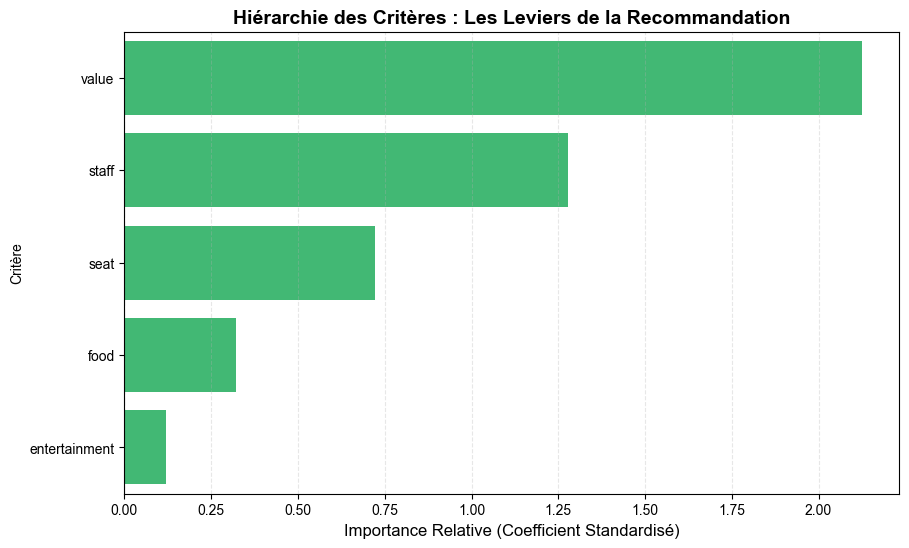


🏆 CLASSEMENT STRATÉGIQUE :
   5. VALUE (Poids: 2.13)
   2. STAFF (Poids: 1.28)
   1. SEAT (Poids: 0.72)
   3. FOOD (Poids: 0.32)
   4. ENTERTAINMENT (Poids: 0.12)

🧠 Entraînement du modèle prédictif NLP (Mode Anti-Triche)...
✅ Précision Globale (Accuracy) : 89.6%
🏆 Score F1 (Mesure Robuste) : 90.6%


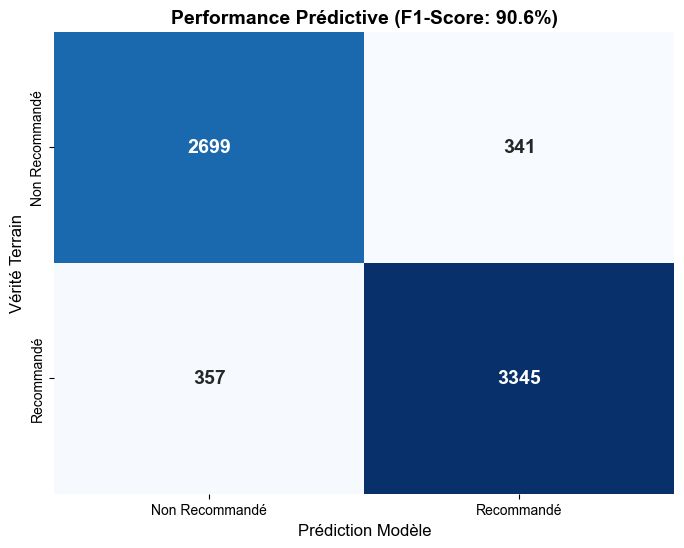

💾 Modélisation terminée.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Configuration graphique
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# --- 1. CHARGEMENT ET SÉCURISATION ---
print("⏳ Chargement des données pour la Modélisation...")
try:
    # On tente de charger le fichier le plus riche (celui avec les clusters)
    df = pd.read_csv('airline_final_analysis.csv')
    print("✅ Données complètes chargées.")
except:
    # Fallback sur le fichier précédent
    df = pd.read_csv('airline_clustered.csv')

# Suppression des cibles manquantes (Indispensable pour le Supervised Learning)
df = df.dropna(subset=['target'])

# --- PARTIE A : ANALYSE DES FACTEURS DÉTERMINANTS (Régression) ---
print("⚙️ Entraînement du modèle explicatif (Facteurs Clés)...")

features = ['seat', 'staff', 'food', 'entertainment', 'value']

# Nettoyage strict pour la régression (Pas de NaN toléré en entrée)
df_clean = df.dropna(subset=features).copy()

X = df_clean[features]
y = df_clean['target'] # 0 (Non Recommandé) ou 1 (Recommandé)

# Standardisation des variables pour comparer les coefficients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modélisation
model_log = LogisticRegression(random_state=42)
model_log.fit(X_scaled, y)

# Extraction et classement des coefficients (Poids)
coefs = pd.DataFrame({
    'Critère': features,
    'Impact': model_log.coef_[0]
}).sort_values(by='Impact', ascending=False)

# Visualisation des Leviers d'Action
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in coefs['Impact']]
sns.barplot(x='Impact', y='Critère', data=coefs, palette=colors)

plt.title("Hiérarchie des Critères : Les Leviers de la Recommandation", fontsize=14, fontweight='bold')
plt.xlabel("Importance Relative (Coefficient Standardisé)", fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

# Affichage console pour le rapport
print("\n🏆 CLASSEMENT STRATÉGIQUE :")
for index, row in coefs.iterrows():
    print(f"   {index+1}. {row['Critère'].upper()} (Poids: {row['Impact']:.2f})")


# --- PARTIE B : PRÉDICTION SÉMANTIQUE (NLP) ---
print("\n🧠 Entraînement du modèle prédictif NLP.")

# Configuration Anti-Leakage : On retire les mots qui "trahissent" la note
leakage_words = ['recommend', 'recommended', 'recommendation', 'flight', 'airline', 'plane', 'trip']
# Fusion avec la liste standard anglaise
my_stop_words = list(ENGLISH_STOP_WORDS) + leakage_words

# Gestion des valeurs nulles dans le texte
df['text'] = df['text'].fillna('')

# Vectorisation TF-IDF (Term Frequency - Inverse Document Frequency)
tfidf = TfidfVectorizer(max_features=5000, stop_words=my_stop_words)
X_text = tfidf.fit_transform(df['text'])
y_text = df['target'] 

# Séparation Train / Test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# Entraînement du classifieur
model_nlp = LogisticRegression(max_iter=1000)
model_nlp.fit(X_train, y_train)

# Évaluation de la performance
y_pred = model_nlp.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Précision Globale (Accuracy) : {acc:.1%}")
print(f"🏆 Score F1 (Mesure Robuste) : {f1:.1%}")

# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14, 'weight': 'bold'},
            xticklabels=['Non Recommandé', 'Recommandé'],
            yticklabels=['Non Recommandé', 'Recommandé'])

plt.title(f"Performance Prédictive (F1-Score: {f1:.1%})", fontsize=14, fontweight='bold')
plt.ylabel("Vérité Terrain", fontsize=12)
plt.xlabel("Prédiction Modèle", fontsize=12)
plt.show()

print("💾 Modélisation terminée.")

🚀 Initialisation de l'analyse Stratégique (Produit & Réseau)...

🧠 Audit de la Valeur Perçue (Premium vs Standard)...
🎯 Capacité de distinction du modèle : 74.4%


C:\Users\luxni\AppData\Local\Temp\ipykernel_23276\2952714210.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Critère', data=coefs, palette='viridis')


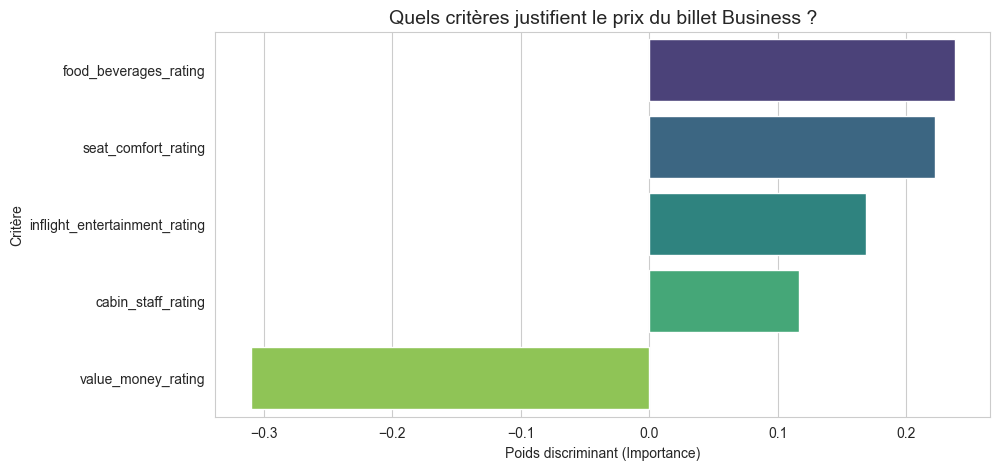


✈️ Benchmarking Flotte : Impact du Constructeur sur le Confort...


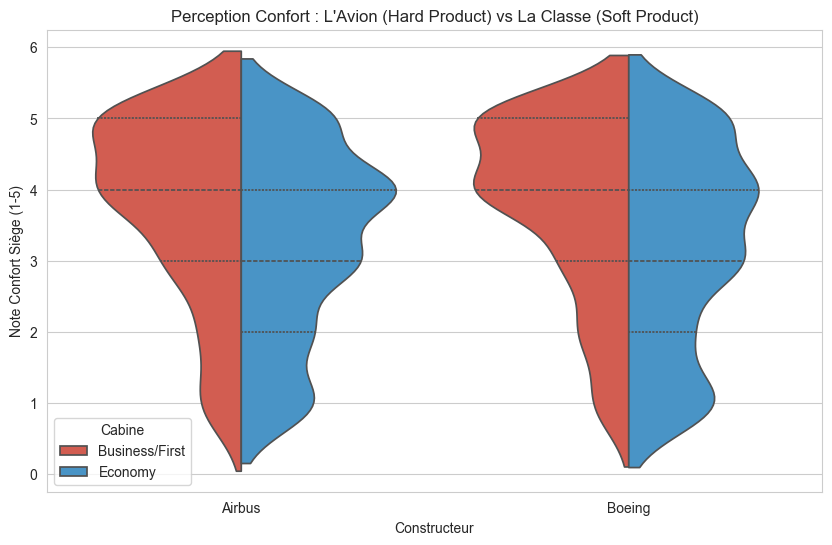

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from geopy.geocoders import Nominatim
import time

# --- 1. PRÉPARATION DES DONNÉES SPÉCIFIQUES ---
print("🚀 Initialisation de l'analyse Stratégique (Produit & Réseau)...")
# On recharge les données brutes pour récupérer les infos 'Avion' et 'Route'
df = pd.read_csv('airline.csv')

# A. Création de la variable cible : Classe de Voyage
# 0 = Standard (Economy), 1 = Premium (Business/First)
def get_class_target(cabin):
    cabin = str(cabin).lower()
    if any(x in cabin for x in ['business', 'first', 'premium']):
        return 1
    elif 'economy' in cabin:
        return 0
    return np.nan

df['is_high_class'] = df['cabin_flown'].apply(get_class_target)

# B. Normalisation du Constructeur (Fleet Management)
def get_manufacturer(text):
    text = str(text).lower()
    if 'airbus' in text or re.search(r'a3\d{2}', text): return 'Airbus'
    if 'boeing' in text or re.search(r'7\d{7}', text) or re.search(r'7\d{2}', text): return 'Boeing'
    return 'Other' # Embraer, Bombardier, etc.

if 'aircraft' in df.columns:
    df['manufacturer'] = df['aircraft'].apply(get_manufacturer)
else:
    df['manufacturer'] = 'Other'

# C. Parsing des Routes (Origine / Destination)
def get_route(text):
    text = str(text)
    if ' to ' in text: return text.split(' to ')[:2]
    if '-' in text: return text.split('-')[:2]
    return [None, None]

if 'route' in df.columns:
    routes = df['route'].apply(get_route)
    df['Origin'] = [x[0].strip() if x[0] else None for x in routes]
    df['Destination'] = [x[1].strip() if x[1] else None for x in routes]

# Filtrage pour l'analyse ML
rating_cols = ['seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 
               'inflight_entertainment_rating', 'value_money_rating']
df_ml = df.dropna(subset=rating_cols + ['is_high_class'])


# --- 2. ANALYSE DE DIFFÉRENCIATION (Business vs Eco) ---
print("\n🧠 Audit de la Valeur Perçue (Premium vs Standard)...")

X = df_ml[rating_cols]
y = df_ml['is_high_class']

# Entraînement d'un modèle pour distinguer les classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

print(f"🎯 Capacité de distinction du modèle : {model.score(X_test, y_test):.1%}")

# Visualisation des marqueurs de différenciation
coefs = pd.DataFrame({'Critère': rating_cols, 'Impact': model.coef_[0]})
coefs = coefs.sort_values(by='Impact', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Impact', y='Critère', data=coefs, palette='viridis')
plt.title("Quels critères justifient le prix du billet Business ?", fontsize=14)
plt.xlabel("Poids discriminant (Importance)")
plt.show()


# --- 3. COMPARATIF INDUSTRIEL (Boeing vs Airbus) ---
print("\n✈️ Benchmarking Flotte : Impact du Constructeur sur le Confort...")

# Focus sur le duopole
df_planes = df_ml[df_ml['manufacturer'].isin(['Boeing', 'Airbus'])].copy()
df_planes['Classe'] = df_planes['is_high_class'].apply(lambda x: 'Business/First' if x == 1 else 'Economy')

# Visualisation Avancée (Split Violin Plot)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.violinplot(data=df_planes, x='manufacturer', y='seat_comfort_rating', hue='Classe', 
               split=True, inner="quart", palette={"Economy": "#3498db", "Business/First": "#e74c3c"})

plt.title("Perception Confort : L'Avion (Hard Product) vs La Classe (Soft Product)", fontsize=12)
plt.xlabel("Constructeur")
plt.ylabel("Note Confort Siège (1-5)")
plt.legend(title='Cabine')
plt.show()




In [ ]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
import time
from collections import Counter

# 1. PRÉPARATION DES DONNÉES
print("🚀 Préparation des données géographiques...")

# On s'assure d'avoir les colonnes Origin/Destination
def get_route(text):
    text = str(text)
    if ' to ' in text: return text.split(' to ')[:2]
    if '-' in text: return text.split('-')[:2]
    return [None, None]

if 'route' in df.columns:
    routes = df['route'].apply(get_route)
    df['Origin'] = [x[0].strip() if x[0] else None for x in routes]
    df['Destination'] = [x[1].strip() if x[1] else None for x in routes]

# On crée une colonne unique "Trajet" pour grouper
df['trajet_str'] = df['Origin'] + " -> " + df['Destination']

# On ne garde que les trajets valides
df_geo = df.dropna(subset=['Origin', 'Destination', 'recommended'])

# 2. CALCUL DE LA SATISFACTION PAR TRAJET

route_stats = df_geo.groupby('trajet_str').agg({
    'recommended': 'mean',  # Moyenne (0 à 1) -> % de recommandation
    'Origin': 'first',      # Juste pour garder le nom
    'Destination': 'first', # Juste pour garder le nom
    'trajet_str': 'count'   # Nombre de vols sur cette ligne
}).rename(columns={'trajet_str': 'nb_vols'})


top_routes = route_stats.sort_values(by='nb_vols', ascending=False).head(100)

print(f"🌍 Analyse de {len(top_routes)} trajets majeurs...")

# 3. GÉOCODAGE (Trouver les coordonnées GPS)
geolocator = Nominatim(user_agent="my_flight_analysis_project_v2")


coords_cache = {}

def get_coords(city):
    if city in coords_cache:
        return coords_cache[city]
    try:
        loc = geolocator.geocode(city, timeout=2)
        if loc:
            coords_cache[city] = [loc.latitude, loc.longitude]
            return [loc.latitude, loc.longitude]
    except:
        return None
    return None

print("📍 Géocodage des villes ")
unique_cities = set(top_routes['Origin']).union(set(top_routes['Destination']))

for i, city in enumerate(unique_cities):
    if i % 5 == 0: print(f"   ... Ville {i}/{len(unique_cities)} : {city}")
    get_coords(city)
    time.sleep(1) 

# 4. CRÉATION DE LA CARTE
m = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodbpositron') 

print("🎨 Dessin des lignes (Vert = Bien, Rouge = Pas bien)...")

for index, row in top_routes.iterrows():
    p1 = coords_cache.get(row['Origin'])
    p2 = coords_cache.get(row['Destination'])
    score = row['recommended'] 
    
    if p1 and p2:
        # LOGIQUE DE COULEUR
        if score >= 0.5:
            color = "#2ecc71" 
            status = "Positif"
        else:
            color = "#e74c3c" # Rouge Vif (Non Recommandé)
            status = "Négatif"
        
    
        weight = min(row['nb_vols'] / 5, 5) 
        
        # Ligne
        folium.PolyLine(
            [p1, p2], 
            color=color, 
            weight=weight, 
            opacity=0.7,
            tooltip=f"{row.name} : {score:.0%} de recommandation ({status})"
        ).add_to(m)

        # Cercles aux aéroports (Origin = Bleu, Dest = Orange)
        folium.CircleMarker(p1, radius=3, color='blue', fill=True).add_to(m)
        folium.CircleMarker(p2, radius=3, color='orange', fill=True).add_to(m)


# 5. SAUVEGARDE
m.save("carte_routes_couleur.html")
print("✅ Terminé !")

🚀 Préparation des données géographiques...
🌍 Analyse de 100 trajets majeurs...
📍 Géocodage des villes 
   ... Ville 0/102 : Las Vegas
   ... Ville 5/102 : Abu Dhabi
   ... Ville 10/102 : Heathrow
   ... Ville 15/102 : Melbourne


KeyboardInterrupt: 